In [1]:
# Install all necessary libraries for the project
!pip install yfinance pandas numpy scikit-learn tensorflow matplotlib

In [11]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np # Already needed for data processing

# --- 1. Configuration ---
STOCK_TICKER = "AAPL"  # Apple Inc. Change this to any stock you want!
START_DATE = "2018-01-01"
END_DATE = datetime.now().strftime('%Y-%m-%d') # Current date
LOOK_BACK_DAYS = 60 # Number of previous days to use for prediction (sequence length for LSTM)
SPLIT_RATIO = 0.8 # 80% of data for training, 20% for testing

# --- 1.1. Data Collection ---
print(f"Fetching data for {STOCK_TICKER} from {START_DATE} to {END_DATE}...")
try:
    # yfinance.download can return a MultiIndex, especially with auto_adjust=True
    df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)

    if df.empty:
        raise ValueError("No data downloaded. Check ticker symbol and date range.")

    print("Data fetched successfully.")
    print("Original df info:")
    df.info()
    print("\nOriginal df head:")
    print(df.head())

    # --- Flatten MultiIndex Columns if they exist ---
    # This is the key fix for yfinance's multi-level columns
    if isinstance(df.columns, pd.MultiIndex):
        # Create new column names like 'Close_AAPL', 'Volume_AAPL'
        df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]
        print("\nFlattened column names:")
        print(df.columns)

    # Now, rename them to simpler names if desired (e.g., 'Close_AAPL' to 'Close')
    # This is optional but makes it cleaner
    df.rename(columns={
        f'Close_{STOCK_TICKER}': 'Close',
        f'High_{STOCK_TICKER}': 'High',
        f'Low_{STOCK_TICKER}': 'Low',
        f'Open_{STOCK_TICKER}': 'Open',
        f'Volume_{STOCK_TICKER}': 'Volume'
    }, inplace=True)
    print("\nRenamed columns for simplicity:")
    print(df.columns)

    print("\nFinal df head after column cleanup:")
    print(df.head())

except Exception as e:
    print(f"Error fetching data: {e}")
    print("Please ensure your ticker symbol is correct and you have an internet connection.")
    print("Example valid tickers: 'AAPL', 'GOOGL', 'MSFT', 'RELIANCE.NS'")
    # In Colab, you might still want to exit if data fails, or just print an error and stop.
    raise # Re-raise to stop execution if data is not loaded

/tmp/ipython-input-11-4214458585.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Fetching data for AAPL from 2018-01-01 to 2025-07-28...
Data fetched successfully.
Original df info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1901 entries, 2018-01-02 to 2025-07-25
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1901 non-null   float64
 1   (High, AAPL)    1901 non-null   float64
 2   (Low, AAPL)     1901 non-null   float64
 3   (Open, AAPL)    1901 non-null   float64
 4   (Volume, AAPL)  1901 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 89.1 KB

Original df head:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.426826  40.436216  39.722772  39.933990  102223600
2018-01-03  40.419785  40.964255  40.356422  40.490191  118071600
2018-01-04  40.607544  40.710806  40.384594  40.492547   897

In [12]:
import pandas_ta as ta # Ensure this is imported here as well for clarity

# --- 2. Feature Engineering ---
print("\nStarting Feature Engineering...")

# Make a copy of the cleaned df from previous cell
df_features = df.copy()

# Add SMA (Simple Moving Average)
df_features['SMA_10'] = ta.sma(df_features['Close'], length=10)
df_features['SMA_20'] = ta.sma(df_features['Close'], length=20)

# Add EMA (Exponential Moving Average)
df_features['EMA_12'] = ta.ema(df_features['Close'], length=12)
df_features['EMA_26'] = ta.ema(df_features['Close'], length=26)

# Add RSI (Relative Strength Index)
df_features['RSI'] = ta.rsi(df_features['Close'], length=14)

# Add MACD (Moving Average Convergence Divergence)
# pandas_ta.macd returns a DataFrame with its own column names like MACD_12_26_9, MACDh_12_26_9, MACDs_12_26_9
macd = ta.macd(df_features['Close'])
if macd is not None and not macd.empty: # Check if it's not None AND not empty
    df_features = df_features.join(macd)
    print("\nMACD columns added.")
else:
    print("MACD could not be calculated or returned empty. Skipping MACD join.")

# Add Bollinger Bands
# pandas_ta.bbands returns a DataFrame with its own column names like BBL_5_2.0, BBM_5_2.0, BBU_5_2.0
bbands = ta.bbands(df_features['Close'])
if bbands is not None and not bbands.empty: # Check if it's not None AND not empty
    df_features = df_features.join(bbands)
    print("Bollinger Bands columns added.")
else:
    print("Bollinger Bands could not be calculated or returned empty. Skipping BBANDS join.")


# Important: Drop NaN values that appear at the beginning due to moving averages
# These NaNs occur because there aren't enough preceding days to calculate the average
initial_rows_before_dropna = len(df_features)
df_features.dropna(inplace=True)
rows_dropped = initial_rows_before_dropna - len(df_features)
print(f"\nDropped {rows_dropped} rows containing NaN values due to initial NaNs from indicators.")


print("\nDataFrame with ALL new technical indicators:")
print(df_features.head())
print(f"New shape after adding features and dropping NaNs: {df_features.shape}")

# --- 2.1. Define Features for the Model ---
# Print all columns to help you decide which ones to use as features
print("\nAvailable columns in df_features after all operations:")
print(df_features.columns)

# Define the list of features you want to use for your model.
# Ensure these names match the actual column names in your df_features.
# Since we flattened and renamed, they should be simple strings now.
features_to_use = [
    'Close',
    'Volume',
    'SMA_10',
    'SMA_20',
    'EMA_12',
    'EMA_26',
    'RSI',
    'MACD_12_26_9', # Default MACD column name by pandas_ta
    'MACDh_12_26_9', # Default MACD Histogram column name
    'MACDs_12_26_9', # Default MACD Signal column name
    'BBL_5_2.0',     # Default Bollinger Band Lower column name
    'BBM_5_2.0',     # Default Bollinger Band Middle column name
    'BBU_5_2.0'      # Default Bollinger Band Upper column name
]

# Select the features and convert to NumPy array for scaling
# Ensure all columns in 'features_to_use' actually exist in 'df_features'
try:
    data = df_features[features_to_use].values
    print(f"\n'data' array for scaling now has shape: {data.shape}")
except KeyError as e:
    print(f"Error: One or more columns in 'features_to_use' not found: {e}")
    print("Please check the 'Available columns in df_features' output and update 'features_to_use' list.")
    raise # Stop execution if columns are missing

# --- 2.2. Scaling Data (from previous Step 2) ---
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(f"Data scaled. Min value: {np.min(scaled_data):.2f}, Max value: {np.max(scaled_data):.2f}")

# --- 2.3. Split Data into Training and Testing Sets (from previous Step 2) ---
train_size = int(len(scaled_data) * SPLIT_RATIO)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size - LOOK_BACK_DAYS:, :] # Include some overlap for testing sequences

print(f"Train data size: {len(train_data)} samples")
print(f"Test data size: {len(test_data)} samples (including look-back for sequences)")

# --- 2.4. Create Sequences for LSTM (from previous Step 2) ---
def create_sequences(dataset, look_back, num_features): # Added num_features argument
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, :]) # Take all features
        Y.append(dataset[i, 0]) # Predict only the 'Close' price (first feature)
    return np.array(X), np.array(Y)

# Get the number of features from your 'data' array
num_features_in_data = data.shape[1]

X_train, y_train = create_sequences(train_data, LOOK_BACK_DAYS, num_features_in_data)
X_test, y_test = create_sequences(test_data, LOOK_BACK_DAYS, num_features_in_data)

# Reshape input to be [samples, time steps, features]
# This line is now correct as 'create_sequences' already handles the 3D shape
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features_in_data)) # No need to reshape here
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features_in_data)) # No need to reshape here

print(f"\nShapes of prepared data:")
print(f"X_train shape (input sequences for training): {X_train.shape}")
print(f"y_train shape (target prices for training): {y_train.shape}")
print(f"X_test shape (input sequences for testing): {X_test.shape}")
print(f"y_test shape (target prices for testing): {y_test.shape}")

print("Data Preprocessing complete!")


Starting Feature Engineering...

MACD columns added.
Bollinger Bands columns added.

Dropped 33 rows containing NaN values due to initial NaNs from indicators.

DataFrame with ALL new technical indicators:
                Close       High        Low       Open     Volume     SMA_10  \
Date                                                                           
2018-02-20  40.495041  41.062935  40.393713  40.542169  135722000  38.736683   
2018-02-21  40.311237  41.029942  40.297096  40.725966  149886400  38.941739   
2018-02-22  40.648205  40.989885  40.462049  40.483256  123967600  39.262395   
2018-02-23  41.355129  41.390474  40.893270  40.923904  135249600  39.756771   
2018-02-26  42.172813  42.271783  41.522443  41.555433  152648800  40.288381   

               SMA_20     EMA_12     EMA_26        RSI  MACD_12_26_9  \
Date                                                                   
2018-02-20  39.093727  39.336674  39.786860  56.689641     -0.450186   
2018-02-21  39.0

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Get the number of features from the preprocessed data's shape
# Assuming X_train's last dimension is the number of features
num_features_for_lstm = X_train.shape[2]

# --- 3. Model Building (LSTM) ---
print("\nBuilding LSTM model...")

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(LOOK_BACK_DAYS, num_features_for_lstm))) # UPDATED INPUT SHAPE
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# ... (rest of your model training code) ...


Building LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,051 (129.11 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)


Evaluating model performance...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Root Mean Squared Error (RMSE): $196.72
Mean Absolute Error (MAE): $194.81

Plotting predictions vs. actual prices...


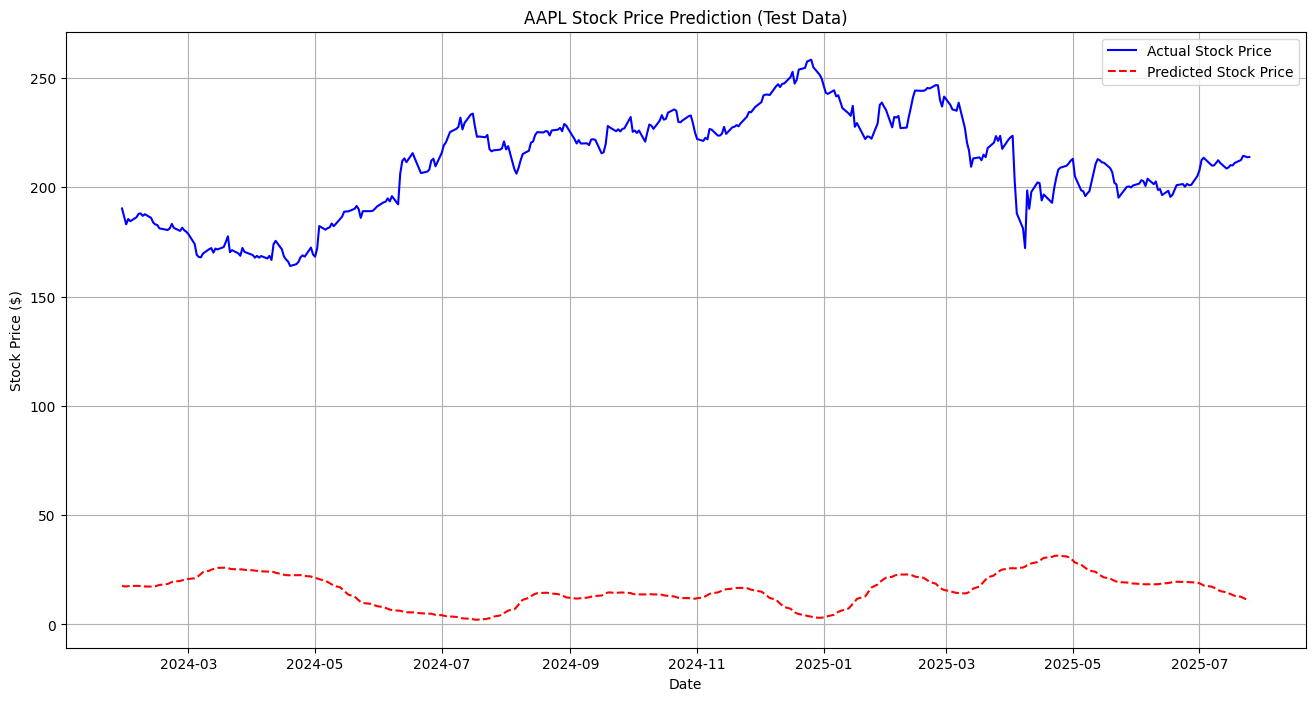

Evaluation and Visualization Complete!

Next steps: Interpret your results and consider how to improve your model for your resume!


In [14]:
# --- 5. Model Evaluation ---
print("\nEvaluating model performance...")

# Generate predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
# Remember: 'scaler' was fit on the original 'Close' price data when creating 'scaled_data'
# We need to create a dummy array with the correct number of features for inverse_transform
# The scaler was fitted on 'data' which has 'num_features_in_data' columns.
# So, we create a zero-filled array of the correct shape and then put our predictions/y_test into the first column.

# For predictions:
dummy_predictions_array = np.zeros((predictions.shape[0], num_features_in_data))
dummy_predictions_array[:, 0] = predictions.flatten() # Put predictions into the 'Close' price slot
predictions_original_scale = scaler.inverse_transform(dummy_predictions_array)[:, 0] # Inverse transform and take only 'Close'

# For y_test:
dummy_y_test_array = np.zeros((y_test.shape[0], num_features_in_data))
dummy_y_test_array[:, 0] = y_test.flatten() # Put y_test into the 'Close' price slot
y_test_original_scale = scaler.inverse_transform(dummy_y_test_array)[:, 0] # Inverse transform and take only 'Close'


# --- 5.1. Calculate Performance Metrics ---
rmse = np.sqrt(np.mean((predictions_original_scale - y_test_original_scale)**2))
mae = np.mean(np.abs(predictions_original_scale - y_test_original_scale))

print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")

# --- 5.2. Visualize Predictions vs. Actual Prices ---
print("\nPlotting predictions vs. actual prices...")

# Create an index for the test data for plotting
# Ensure 'df_features' is the DataFrame with all features and dropped NaNs
# The test data starts from the point where the training data ends, plus the LOOK_BACK_DAYS offset
# It's better to use the index from df_features directly after it was cleaned and had NaNs dropped.
# We need to find the correct starting index for the test_dates.
# X_test.shape[0] is the number of predictions we made.
# df_features.index will be the dates of the data after dropping NaNs.
test_dates = df_features.index[-len(y_test_original_scale):]


plt.figure(figsize=(16, 8))
plt.plot(test_dates, y_test_original_scale, color='blue', label='Actual Stock Price')
plt.plot(test_dates, predictions_original_scale, color='red', linestyle='--', label='Predicted Stock Price')
plt.title(f'{STOCK_TICKER} Stock Price Prediction (Test Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.show()

print("Evaluation and Visualization Complete!")
print("\nNext steps: Interpret your results and consider how to improve your model for your resume!")

In [15]:
import os
import joblib

# Create a directory to save the model and scaler
model_save_dir = 'stock_prediction_artifacts'
os.makedirs(model_save_dir, exist_ok=True)

# Save the trained Keras model
# The '.keras' format is the recommended way to save TensorFlow Keras models
model.save(os.path.join(model_save_dir, 'my_lstm_stock_predictor.keras'))
print(f"Model saved to {model_save_dir}/my_lstm_stock_predictor.keras")

# Save the MinMaxScaler (which was fitted on all your features)
joblib.dump(scaler, os.path.join(model_save_dir, 'minmax_scaler_all_features.pkl'))
print(f"Scaler saved to {model_save_dir}/minmax_scaler_all_features.pkl")

# --- Optional: Verify loading ---
from tensorflow.keras.models import load_model
loaded_model = load_model(os.path.join(model_save_dir, 'my_lstm_stock_predictor.keras'))
loaded_scaler = joblib.load(os.path.join(model_save_dir, 'minmax_scaler_all_features.pkl'))

print("\nModel and Scaler successfully loaded back for verification.")
# You can optionally make a test prediction with loaded_model and loaded_scaler
# to ensure they work as expected.

Model saved to stock_prediction_artifacts/my_lstm_stock_predictor.keras
Scaler saved to stock_prediction_artifacts/minmax_scaler_all_features.pkl

Model and Scaler successfully loaded back for verification.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
